# 1. Is this your favorite food?

In this kaggle competition, our task is to predict where is the food from based on its ingredients. As the head chef in my family, I can not wait to explore these gourmets data. 

Load the data and take a look.

In [1]:
import json
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

def load_data(filename):
    with open(filename, 'r') as f:
        data = json.load(f)
    df = pd.DataFrame(data)    
    return df

train=load_data("../input/train.json")
test=load_data("../input/test.json")

train.sample(5)

,cuisine,id,ingredients
18172,thai,47080,"[brown sugar, sesame oil, garlic cloves, curry..."
25862,russian,15195,"[sorrel, ground pepper, yellow onion, cream, f..."
16425,mexican,10491,"[yellow bell pepper, freshly ground pepper, to..."
38032,cajun_creole,10542,"[pepper, diced tomatoes, onions, green bell pe..."
38180,filipino,37948,"[carrots, beef brisket, onions, fish sauce, bo..."


There are 39774 entries in the train set. And no missing values is found in the train set.

In [2]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39774 entries, 0 to 39773
Data columns (total 3 columns):
cuisine        39774 non-null object
id             39774 non-null int64
ingredients    39774 non-null object
dtypes: int64(1), object(2)
memory usage: 932.3+ KB


# 2. Feature Engineering and data exploring

Clean the ingredients and convert it from list to text. Add length of ingredients as a new feature.

In [3]:
import re
from nltk.stem import WordNetLemmatizer
from tqdm import tqdm
tqdm.pandas()

lemmatizer = WordNetLemmatizer()
def preprocess(ingredients):
    ingredients_text=" ".join(ingredients)
    ingredients_text=ingredients_text.lower()
    ingredients_text=ingredients_text.replace("-",'')
    ingredients_text=ingredients_text.replace("'",'')
    sentence=[]
    for word in ingredients_text.split():
        if re.findall('[0-9]',word): continue
        if len(word)<=2: continue
        word=lemmatizer.lemmatize(word)
        sentence.append(word)
    return " ".join(sentence)
                
train['ingredients_text']=train['ingredients'].progress_apply(lambda x: preprocess(x))
train=train.drop(['ingredients'],axis=1)
train["ingredients_len"]=train['ingredients_text'].apply(lambda x: len(x.split()))

test['ingredients_text']=test['ingredients'].progress_apply(lambda x: preprocess(x))
test=test.drop(['ingredients'],axis=1)
test["ingredients_len"]=test['ingredients_text'].apply(lambda x: len(x.split()))



100%|██████████| 9944/9944 [00:01<00:00, 8153.55it/s]


In [4]:
train.sample(5)

,cuisine,id,ingredients_text,ingredients_len
17435,vietnamese,30772,bread garlic butter spring onion sugar salt,7
18871,italian,26292,chicken stock grated parmesan cheese extravirg...,24
25045,japanese,34024,light soy sauce toasted sesame seed sugar beef...,13
3759,mexican,16969,warm water active dry yeast salt garlic clove ...,32
23574,irish,8810,soy sauce nutritional yeast parsley vital whea...,41


Italian food is most popular in the train set.

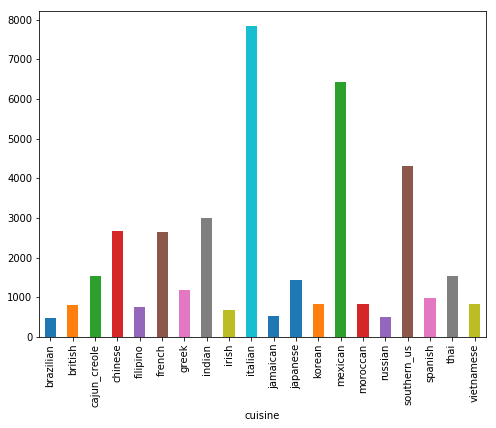

In [5]:
import matplotlib.pyplot as plt
fig=plt.figure(figsize=(8,6))
train.groupby('cuisine')['id'].count().plot.bar()
plt.show()

The Thai, Cajun_creole,Chinese food have more variety of ingredients. The Irish,british, Russian and filipino food have simple ingredients. Compare to the importance of ingredients themselves, I decide not to take it as a new feature.

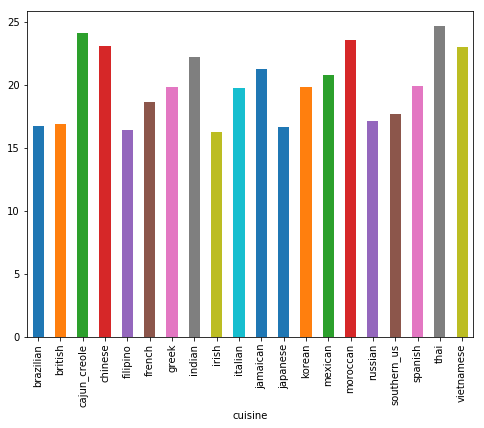

In [6]:
fig=plt.figure(figsize=(8,6))
train.groupby('cuisine')['ingredients_len'].mean().plot.bar()
plt.show()

It looks like every kind of cuisine has top ingredients. For Chinese food, the soy sauce, sesame oil, corn starch are frequetly used.For Italian dish, the olive oil, pamemsen cheese, black pepper are frequetly used.

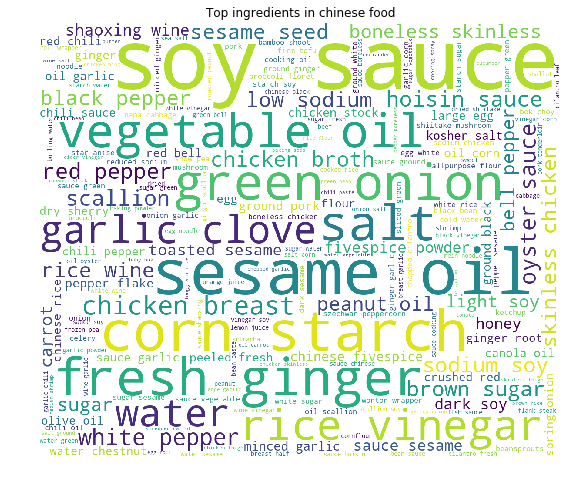

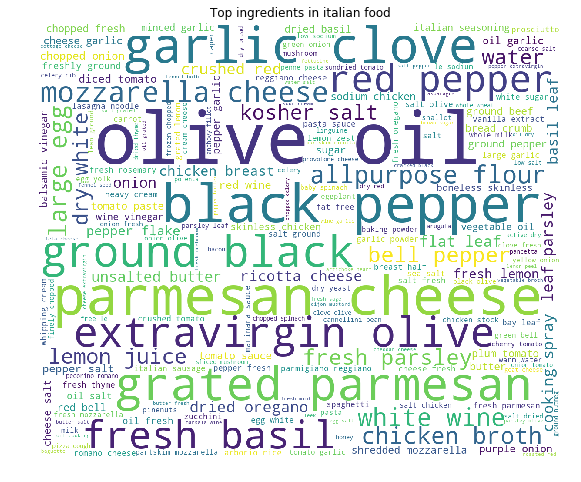

In [7]:
from wordcloud import WordCloud
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))

def cloud_words(cuisine):
    text = ' '.join(train[train['cuisine']==cuisine]['ingredients_text'].values)
    wordcloud = WordCloud(max_font_size=None, stopwords=stop, background_color='white',
                          width=1200, height=1000).generate(text)
    plt.figure(figsize=(12, 8))
    plt.imshow(wordcloud)
    plt.title('Top ingredients in '+ cuisine+' food')
    plt.axis("off")
    plt.show()
    
cloud_words("chinese")
cloud_words("italian")

Use tfidfVectorizer to convert ingredients into vectors. After vectorizing, the total number of features is 2870.

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer, LabelEncoder

vectorizer=make_pipeline(
                        TfidfVectorizer(),
                        FunctionTransformer(lambda x: x.astype('float16'), validate=False)
                        )
X_train=vectorizer.fit_transform(train['ingredients_text'].values)
X_test=vectorizer.transform(test['ingredients_text'].values)

X_train.shape

(39774, 2832)

Use the lableEncoder to encode the labels from names to numeric values.

In [9]:
LabelEncoder=LabelEncoder()
y_train=LabelEncoder.fit_transform(train['cuisine'].values)
label_dict=dict(zip(LabelEncoder.classes_,LabelEncoder.transform(LabelEncoder.classes_)))
print(label_dict)

{'brazilian': 0, 'british': 1, 'cajun_creole': 2, 'chinese': 3, 'filipino': 4, 'french': 5, 'greek': 6, 'indian': 7, 'irish': 8, 'italian': 9, 'jamaican': 10, 'japanese': 11, 'korean': 12, 'mexican': 13, 'moroccan': 14, 'russian': 15, 'southern_us': 16, 'spanish': 17, 'thai': 18, 'vietnamese': 19}


# 3. Model training

## 3.1 Baseline model
we try a couple of models as baseline. As the result, the LinearSVC and LogisticRegression have better accuracy. 

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score,cross_validate
import seaborn as sns

#Initiallly explore the models 
def model_explore(X, y):
    models = [
        RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
        SVC(),
        LinearSVC(),
        MultinomialNB(),
        LogisticRegression(random_state=0),
        SGDClassifier(max_iter=200),
    ]
    CV = 5
    cv_df = pd.DataFrame(index=range(CV * len(models)))
    entries = []
    for model in models:
        model_name = model.__class__.__name__
        accuracies = cross_val_score(model, X, y, scoring='accuracy', cv=CV)
        for fold_idx, accuracy in enumerate(accuracies):
            entries.append((model_name, fold_idx, accuracy))
    cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
    sns.boxplot(x='model_name', y='accuracy', data=cv_df)
    sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
                  size=5, jitter=True, edgecolor="gray", linewidth=2)
    plt.show()
    return cv_df

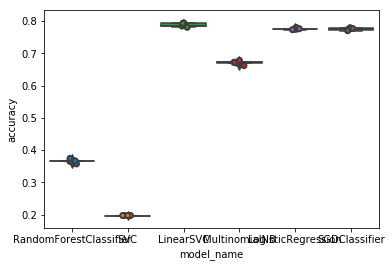

model_name
LinearSVC                 0.788204
LogisticRegression        0.776135
MultinomialNB             0.671142
RandomForestClassifier    0.365921
SGDClassifier             0.775330
SVC                       0.197063
Name: accuracy, dtype: float64

In [11]:
cv_baseline=model_explore(X_train, y_train)
cv_baseline.groupby("model_name").accuracy.mean()

## 3.2 estimator+OneVsRestClassifier+CV
On consider that this is a multi_class classificaiton. Let us try OneVsRestClassifier.

### 3.2.1 SVC+OneVsRestClassifier+CV

In [12]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import cross_val_score,cross_validate


classifier_SVC = SVC(C=200, # penalty parameter
                 kernel='rbf', # kernel type, rbf working fine here
                 degree=3, # default value
                 gamma=1, # kernel coefficient
                 coef0=1, # change to 1 from default value of 0.0
                 shrinking=True, # using shrinking heuristics
                 tol=0.001, # stopping criterion tolerance 
                 probability=False, # no need to enable probability estimates
                 cache_size=1000, # 200 MB cache size
                 class_weight=None, # all classes are treated equally 
                 verbose=False, # print the logs 
                 max_iter=-1, # no limit, let it run
                 decision_function_shape=None, # will use one vs rest explicitly 
                 random_state=None)

model_SVC_OVR = OneVsRestClassifier(classifier_SVC)

scores_SVC = cross_validate(model_SVC_OVR, X_train, y_train, cv=3)

print("The test accuracy of SVC is {}".format(scores_SVC['test_score'].mean()))

The test accuracy of SVC is 0.8104043092164716


### 3.2.2 SGD+OneVsRestClassifier+CV

In [13]:
SGD=SGDClassifier(max_iter=1000)
model_SGD_OVR = OneVsRestClassifier(SGD)
scores_SGD = cross_validate(model_SGD_OVR, X_train, y_train, cv=3)

print("The test accuracy of SGD is {}".format(scores_SGD['test_score'].mean()))

The test accuracy of SGD is 0.7739978920256579


### 3.2.3 LinearSVC+OneVsRestClassifier+CV

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score,cross_validate

Linear_SVC=LinearSVC()
model_LinearSVC_OVR = OneVsRestClassifier(Linear_SVC)
scores_LinearSVC = cross_validate(model_LinearSVC_OVR, X_train, y_train, cv=3)

print("The test accuracy of LinearSVC is {}".format(scores_LinearSVC['test_score'].mean()))

The test accuracy of LinearSVC is 0.7846834249616066


### 3.2.4 LogisticRegression+OneVsRestClassifier+CV

In [15]:
LogisticRegression=LogisticRegression(random_state=2019)
model_LogisticRegression_OVR = OneVsRestClassifier(LogisticRegression)
scores_LogisticRegression = cross_validate(model_LogisticRegression_OVR, X_train, y_train, cv=3)

print("The test accuracy of LogisticRegression is {}".format(scores_LogisticRegression['test_score'].mean()))

The test accuracy of LogisticRegression is 0.7720872645517513


## 3.3 Predict the test set and submit

The SVC+OneVsRestClssifier estimator has the best accuracy. Fit this model and predict the test set for submission. 

In [16]:
model_SVC_OVR.fit(X_train,y_train)
y_pred=model_SVC_OVR.predict(X_test)

y_pred=LabelEncoder.inverse_transform(y_pred)
test['cuisine']=y_pred
test[['id','cuisine']].to_csv("submission.csv",index=False)
